# Random Forest Classification Model

Set up spark context and SparkSession

In [1]:
try:
    sc.stop
except:
    pass

from pyspark import SparkContext , SparkConf
from pyspark.sql import SparkSession
sc = SparkContext.getOrCreate()
spark = SparkSession(sparkContext = sc)

22/10/06 21:52:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/10/06 21:52:21 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Load dataset

In [2]:
df = spark.read.format('csv') \
            .options(header='true', inferschema='true') \
            .options(delimiter=',')\
            .load("./data/WineData.csv",header=True);
df.show(5)


+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4|      5|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8|      5|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8|      5|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [3]:
df.cache()

df.printSchema()


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: integer (nullable = true)



Deal with categorical data and Convert the data to dense vector

In [4]:
# Convert to float format
def string_to_float(x):
    return float(x)

#
def condition(r):
    if (0<= r <= 4):
        label = "low"
    elif(4< r <= 6):
        label = "medium"
    else:
        label = "high"
    return label

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, DoubleType
string_to_float_udf = udf(string_to_float, DoubleType())
quality_udf = udf(lambda x: condition(x), StringType())

df = df.withColumn("quality", quality_udf("quality"))

df.show(5,True)

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.4|             0.7|        0.0|           1.9|    0.076|               11.0|                34.0| 0.9978|3.51|     0.56|    9.4| medium|
|          7.8|            0.88|        0.0|           2.6|    0.098|               25.0|                67.0| 0.9968| 3.2|     0.68|    9.8| medium|
|          7.8|            0.76|       0.04|           2.3|    0.092|               15.0|                54.0|  0.997|3.26|     0.65|    9.8| medium|
|         11.2|            0.28|       0.56|           1.9|    0.075|               17.0|           

In [5]:
df.printSchema()


root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: string (nullable = true)



In [6]:
def get_dummy(df,categoricalCols,continuousCols,labelCol):

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()))
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    data = data.withColumn('label',col(labelCol))

    return data.select('features','label')

Transform the dataset to DataFrame

In [7]:
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def transData(data):
    return data.rdd.map(lambda r: [Vectors.dense(r[:-1]),r[-1]]).toDF(['features','label'])

In [8]:
transformed = transData(df)
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



Deal with Categorical Label and Variables

In [9]:
# Index labels, adding metadata to the label column
labelIndexer = StringIndexer(inputCol='label',
                             outputCol='indexedLabel').fit(transformed)
labelIndexer.transform(transformed).show(5, True)

+--------------------+------+------------+
|            features| label|indexedLabel|
+--------------------+------+------------+
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
|[7.8,0.88,0.0,2.6...|medium|         0.0|
|[7.8,0.76,0.04,2....|medium|         0.0|
|[11.2,0.28,0.56,1...|medium|         0.0|
|[7.4,0.7,0.0,1.9,...|medium|         0.0|
+--------------------+------+------------+
only showing top 5 rows



In [10]:
transformed.show(5)

+--------------------+------+
|            features| label|
+--------------------+------+
|[7.4,0.7,0.0,1.9,...|medium|
|[7.8,0.88,0.0,2.6...|medium|
|[7.8,0.76,0.04,2....|medium|
|[11.2,0.28,0.56,1...|medium|
|[7.4,0.7,0.0,1.9,...|medium|
+--------------------+------+
only showing top 5 rows



In [11]:
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", \
                              outputCol="indexedFeatures", \
                              maxCategories=4).fit(transformed)
featureIndexer.transform(transformed).show(5, True)

+--------------------+------+--------------------+
|            features| label|     indexedFeatures|
+--------------------+------+--------------------+
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
|[7.8,0.88,0.0,2.6...|medium|[7.8,0.88,0.0,2.6...|
|[7.8,0.76,0.04,2....|medium|[7.8,0.76,0.04,2....|
|[11.2,0.28,0.56,1...|medium|[11.2,0.28,0.56,1...|
|[7.4,0.7,0.0,1.9,...|medium|[7.4,0.7,0.0,1.9,...|
+--------------------+------+--------------------+
only showing top 5 rows



Split the data to training and test data sets

In [12]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = transformed.randomSplit([0.6, 0.4])

trainingData.show(5,False)
testData.show(5,False)

+---------------------------------------------------------+------+
|features                                                 |label |
+---------------------------------------------------------+------+
|[5.0,0.38,0.01,1.6,0.048,26.0,60.0,0.99084,3.7,0.75,14.0]|medium|
|[5.0,0.4,0.5,4.3,0.046,29.0,80.0,0.9902,3.49,0.66,13.6]  |medium|
|[5.0,0.42,0.24,2.0,0.06,19.0,50.0,0.9917,3.72,0.74,14.0] |high  |
|[5.0,0.74,0.0,1.2,0.041,16.0,46.0,0.99258,4.01,0.59,12.5]|medium|
|[5.0,1.04,0.24,1.6,0.05,32.0,96.0,0.9934,3.74,0.62,11.5] |medium|
+---------------------------------------------------------+------+
only showing top 5 rows

+----------------------------------------------------------+------+
|features                                                  |label |
+----------------------------------------------------------+------+
|[4.6,0.52,0.15,2.1,0.054,8.0,65.0,0.9934,3.9,0.56,13.1]   |low   |
|[4.7,0.6,0.17,2.3,0.058,17.0,106.0,0.9932,3.85,0.6,12.9]  |medium|
|[4.9,0.42,0.0,2.1,0.048,16.0,42

## Fit Random Forest Classification Model

In [13]:
# Fit Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors # !!!!caution: not from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import IndexToString,StringIndexer, VectorIndexer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

Convert indexed labels back to original labels.


In [14]:
# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and tree in a Pipeline

In [15]:
# Chain indexers and tree in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf,labelConverter])

Train model.  This also runs the indexers.

In [16]:
trainingData.show()

+--------------------+------+
|            features| label|
+--------------------+------+
|[5.0,0.38,0.01,1....|medium|
|[5.0,0.4,0.5,4.3,...|medium|
|[5.0,0.42,0.24,2....|  high|
|[5.0,0.74,0.0,1.2...|medium|
|[5.0,1.04,0.24,1....|medium|
|[5.1,0.42,0.0,1.8...|  high|
|[5.1,0.47,0.02,1....|medium|
|[5.2,0.32,0.25,1....|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.34,0.0,1.8...|medium|
|[5.2,0.48,0.04,1....|  high|
|[5.2,0.49,0.26,2....|medium|
|[5.3,0.47,0.11,2....|  high|
|[5.3,0.47,0.11,2....|  high|
|[5.3,0.715,0.19,1...|medium|
|[5.4,0.42,0.27,2....|  high|
|[5.4,0.58,0.08,1....|medium|
|[5.4,0.74,0.0,1.2...|medium|
|[5.5,0.49,0.03,1....|  high|
|[5.6,0.31,0.37,1....|medium|
+--------------------+------+
only showing top 20 rows



In [17]:
model = pipeline.fit(trainingData)

Make predictions.

In [18]:
predictions = model.transform(testData)

Select example rows to display.

In [19]:
predictions.select("features","label","predictedLabel").show(5)

+--------------------+------+--------------+
|            features| label|predictedLabel|
+--------------------+------+--------------+
|[4.6,0.52,0.15,2....|   low|        medium|
|[4.7,0.6,0.17,2.3...|medium|        medium|
|[4.9,0.42,0.0,2.1...|  high|        medium|
|[5.0,1.02,0.04,1....|   low|        medium|
|[5.1,0.51,0.18,2....|  high|          high|
+--------------------+------+--------------+
only showing top 5 rows



# Evaluation

In [20]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[-2]
print(rfModel)  # summary only

Test Error = 0.161189
RandomForestClassificationModel: uid=RandomForestClassifier_df016c6f1a15, numTrees=10, numClasses=3, numFeatures=11


visualization

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
class_temp = predictions.select("label").groupBy("label")\
                        .count().sort('count', ascending=False).toPandas()
class_names = class_temp["label"].values.tolist()
class_names

['medium', 'high', 'low']

In [22]:
from sklearn.metrics import confusion_matrix
y_true = predictions.select("label")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[509,  10,   0],
       [ 68,  27,   0],
       [ 24,   1,   0]])

Confusion matrix, without normalization
[[509  10   0]
 [ 68  27   0]
 [ 24   1   0]]


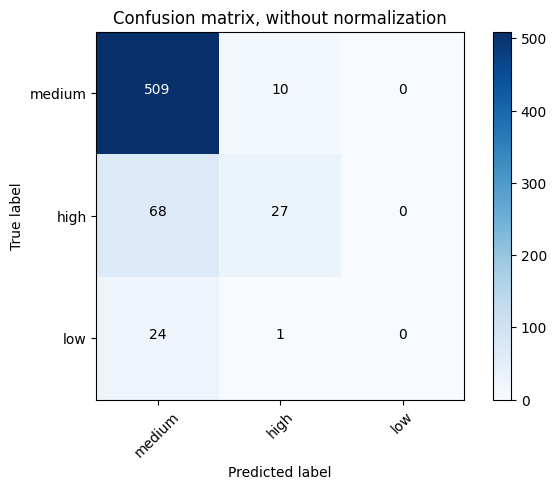

In [23]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show();

Normalized confusion matrix
[[0.98073218 0.01926782 0.        ]
 [0.71578947 0.28421053 0.        ]
 [0.96       0.04       0.        ]]


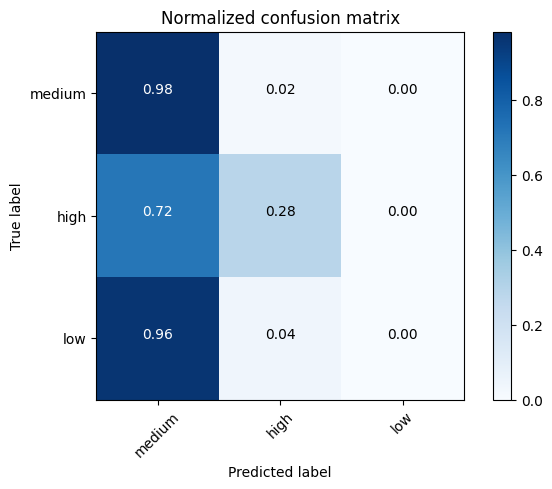

In [24]:
# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()